<a href="https://colab.research.google.com/github/Gardiy/Multi-SER-pe-/blob/main/Multi-speaker-datacreate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias y descargas

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import save
import shutil
import math
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import random
from keras.models import model_from_json
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Audio
from IPython.core.display import display
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pprint
import statistics
import seaborn as sns
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess

try:
        import speechmetrics as sm
except ImportError:
        print('Instalando paquetes...')
        subprocess.check_call(["python", '-m', 'pip', 'install', 'git+https://github.com/aliutkus/speechmetrics#egg=speechmetrics[cpu]'])
        import speechmetrics as sm

Instalando paquetes...


In [ ]:
%%capture
!git clone https://github.com/speechbrain/speechbrain/
!pip install speechbrain
!pip install transformers
import speechbrain as sb
from speechbrain.dataio.dataio import read_audio
from speechbrain.pretrained import SepformerSeparation as separator

In [ ]:
%%capture
!pip install -U asteroid
import asteroid
from asteroid.models import BaseModel
from asteroid.models import ConvTasNet
import soundfile as sf

# Funcion de union de audios y metricas

In [ ]:
window = 8
metrics = sm.load(['relative.pesq', 'relative.stoi', 'relative.sisdr'], window)

Loaded  speechmetrics.relative.pesq
Loaded  speechmetrics.relative.sisdr
Loaded  speechmetrics.relative.stoi


In [ ]:
def merge_audios(audio1_path, audio2_path, overlap_percentage, volume_ratio):

    if volume_ratio > 0:
      flag_val = 1
    elif volume_ratio < 0:
      flag_val = 2
    else:
      flag_val = 0

   # Cargar los archivos de audio
    audio1, sr = librosa.load(audio1_path, sr=None)
    audio2, sr = librosa.load(audio2_path, sr=None)

    # Obtener la duración de cada audio
    duration1 = len(audio1) / sr
    duration2 = len(audio2) / sr

    # Determinar el audio más largo y el más corto
    if duration1 >= duration2:
        long_audio = audio1
        short_audio = audio2
    else:
        long_audio = audio2
        short_audio = audio1

    # Asegurarse de que el audio más corto tenga la misma duración que el más largo
    long_audio = long_audio[:len(short_audio)]

    audio1 = short_audio
    audio2 = long_audio

    # Ajustar el volumen del segundo audio según la razón en dB
    rms_audio1 = librosa.feature.rms(y = audio1).mean()
    rms_audio2 = librosa.feature.rms(y = audio2).mean()

    # Calcular el valor RMS de cada audio
    dB_rms_audio1 = 10*math.log(rms_audio1)
    dB_rms_audio2 = 10*math.log(rms_audio2)

    # Calcular la relación de amplitud entre los audios
    relacion_amplitud = volume_ratio - (dB_rms_audio1 - dB_rms_audio2)
    relacion_amplitud += rms_audio1

    # Ajustar el volumen del audio2 utilizando el factor de ajuste
    factor_ajuste = math.pow(10, relacion_amplitud / 10)
    audio1_ajustado = audio1 * factor_ajuste


    # Calcular la duración de la superposición
    overlap_samples = int(len(audio1_ajustado) * overlap_percentage)

    audio1_padded = np.pad(audio1_ajustado, (overlap_samples, 0), mode='constant')


    # Obtener la duración de cada audio
    duration1 = len(audio1_padded) / sr
    duration2 = len(audio2) / sr

    # Determinar el audio más largo y el más corto
    if duration1 >= duration2:
        long_audio = audio1_padded
        short_audio = audio2
    else:
        long_audio = audio2
        short_audio = audio1_padded

    # Asegurarse de que el audio más corto tenga la misma duración que el más largo
    short_audio = np.pad(short_audio, (0, len(long_audio) - len(short_audio)))


    # Combinar los audios
    merged_audio = long_audio + short_audio

    # Normalizar el audio
    merged_audio = librosa.util.normalize(merged_audio)

    return merged_audio, sr, flag_val

#SER
Se especifica las emociones y la frecuencia de muestreo que usara el modelo

In [ ]:
# Cargar arquitectura del modelo desde archivo JSON
with open('/content/drive/MyDrive/Tesis/modeloRCTS_8k_3emot.json', 'r') as json_file:
    loaded_model_json = json_file.read()
MODEL = model_from_json(loaded_model_json)

# Cargar pesos al modelo
MODEL.load_weights("/content/drive/MyDrive/Tesis/pesosRCTS_8k_3emot.h5")

In [ ]:
!pip install pydub
from pydub import AudioSegment, effects
from tensorflow.keras.utils import to_categorical

In [ ]:
# longo = 180000
#longo = 128000 # 16k
longo = 64000 # 8k
def preprocess_audio(path):
    y, sr = librosa.load(path, sr=None)

    # raw_audio = AudioSegment.from_file(path)
    # samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')

    samples = librosa.util.normalize(y)

    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if len(trimmed) < longo:
      padded = np.pad(trimmed, (0, longo-len(trimmed)), 'constant')
    else:
      padded = trimmed[:longo]
    return padded, sr

emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'angry'   : 2
}

def encode(label):
    return emotion_dic.get(label)

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

def extract_features(path):
    try:
        y, sr = preprocess_audio(path)

        y = librosa.util.normalize(y)

        # display(Audio(y, rate=sr))
        # print('Frecuencia de muestreo = ', sr)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

    except:
        print(f"Failed for path: {path}")

# Mezcla de audios

## Base de datos

### Creacion

In [ ]:
# Datos a 8 kHz
datos_osiles = pd.read_csv('/content/drive/MyDrive/Tesis/datos_osiles_8k.csv')

print(datos_osiles.shape)
datos_osiles.head()

(5659, 6)


,path1,emotion1,persona1,path2,emotion2,persona2
0,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,angry,C_88,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,happy,C_39
1,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_84,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,angry,C_73
2,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_64,/content/drive/MyDrive/Tesis/RCST_8k/TESS/YAF_...,disgust,T_YAF
3,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,sad,C_72,/content/drive/MyDrive/Tesis/RCST_8k/TESS/YAF_...,fear,T_YAF
4,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,happy,C_15,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_10


In [ ]:
mini_acum = datos_osiles[datos_osiles['emotion1'].isin(['happy', 'neutral', 'angry'])]
mini_acum = mini_acum[mini_acum['emotion2'].isin(['happy', 'neutral', 'angry'])]
#mini_acum = mini_acum[mini_acum['emotion1'] != mini_acum['emotion2']]
print(mini_acum.shape)

(1319, 6)


In [ ]:
mini = datos_osiles.sample(600)
print(mini.shape)
mini.head()

(600, 6)


,path1,emotion1,persona1,path2,emotion2,persona2
1654,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_30,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_56
4326,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,happy,C_86,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_87
5121,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,fear,C_70,/content/drive/MyDrive/Tesis/RCST_8k/TESS/YAF_...,fear,T_YAF
125,/content/drive/MyDrive/Tesis/RCST_8k/Ravdess/0...,neutral,R_19,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,angry,C_81
4121,/content/drive/MyDrive/Tesis/RCST_8k/TESS/YAF_...,happy,T_YAF,/content/drive/MyDrive/Tesis/RCST_8k/CremaD/10...,disgust,C_22


In [ ]:
mini.to_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_6emot.csv', index=False)

### Carga

In [ ]:
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
# mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot_rep.csv')

limite = len(mini) # Barra de progreso
limite

300

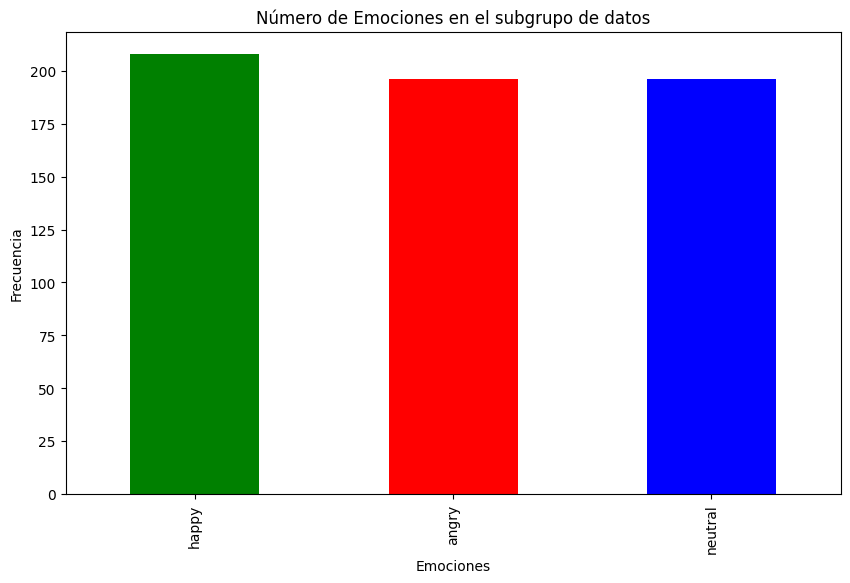

In [ ]:
# Grafica de la distribucion de meocines cuando se eligen muestras de manera aleatoria
emotions = pd.concat([mini["emotion1"], mini["emotion2"]])

# Contar la frecuencia de cada emoción
emotion_counts = emotions.value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color = ['green', 'red', 'blue'])
plt.xlabel('Emociones')
plt.ylabel('Frecuencia')
plt.title('Número de Emociones en el subgrupo de datos')
plt.show()

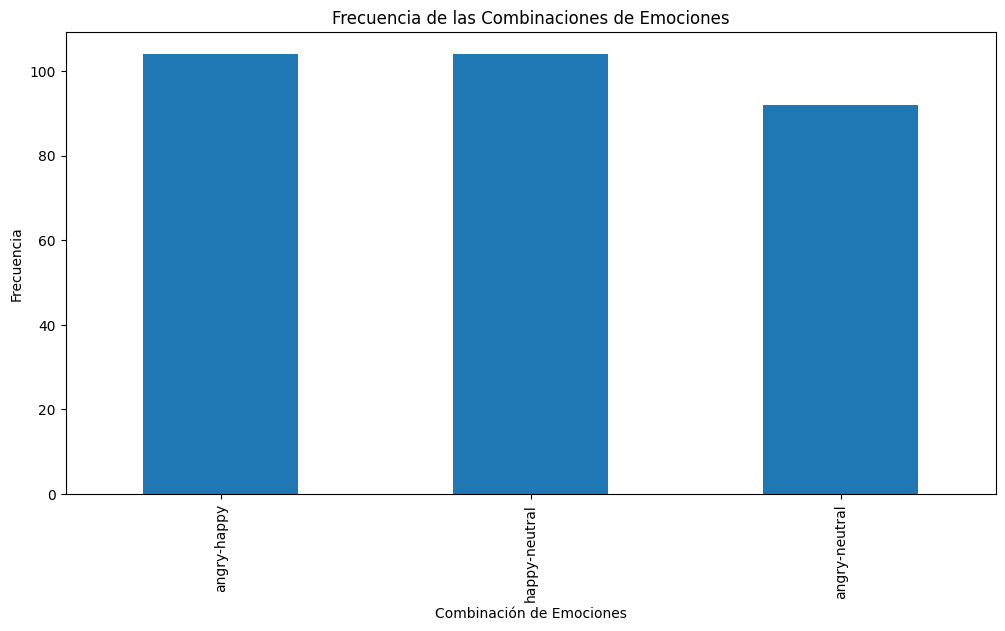

In [ ]:
combinacion = mini[["emotion1", "emotion2"]].apply(lambda x: "-".join(sorted(x)), axis=1)

# Contar la frecuencia de cada combinación de emociones
combinacion_counts = combinacion.value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
combinacion_counts.plot(kind='bar')
plt.xlabel('Combinación de Emociones')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de las Combinaciones de Emociones')
plt.show()

### Overlap y volumen

In [ ]:
opciones_overlap = [0.2, 0.4, 0.6, 0.8, 1]
#opciones_overlap = [0]
opciones_volume = [-3, -2, -1, 0, 1, 2, 3]
#opciones_volume = [0]

vector_volumen = [random.choice(opciones_volume) for _ in range(600)]
vector_overlap = [random.choice(opciones_overlap) for _ in range(600)]

In [ ]:
save('vector_volumen.npy', vector_volumen)
shutil.copyfile("vector_volumen.npy", "/content/drive/MyDrive/Tesis/vector_volumen_6emot.npy")

'/content/drive/MyDrive/Tesis/vector_volumen_6emot.npy'

In [ ]:
save('vector_overlap.npy', vector_overlap)
shutil.copyfile("vector_overlap.npy", "/content/drive/MyDrive/Tesis/vector_overlap_3emot_overlap.npy")

'/content/drive/MyDrive/Tesis/vector_overlap_3emot_overlap.npy'

In [ ]:
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
vector_overlap = np.load('/content/drive/MyDrive/Tesis/vector_overlap_3emot_overlap.npy')

### Añadir ruido

In [ ]:
def sum_noise(merged_audio):
  ruta_ruido = "/content/drive/MyDrive/Tesis/WHAM noise/sub_300_8k/"

  archivos_ruido = os.listdir(ruta_ruido)

  # Cargar el archivo de audio normal
  audio_normal = merged_audio

  # Seleccionar un archivo de ruido aleatoriamente
  archivo_ruido = archivos_ruido[acum_indice]
  archivo_ruido = ruta_ruido + archivo_ruido

  # Cargar el archivo de ruido
  audio_ruido, sr = librosa.load(archivo_ruido, sr=None)

  # Ajustar la duración del ruido a la duración del audio normal
  if len(audio_ruido) > len(audio_normal):
      audio_ruido = audio_ruido[:len(audio_normal)]
  else:
      audio_ruido = audio_ruido + audio_ruido[:len(audio_normal) - len(audio_ruido)]

  audio_ruido /= (2/3)

  # Combinar el audio normal con el ruido
  audio_combinado = audio_normal + audio_ruido

  return audio_combinado

In [ ]:
def save_preprocess(audio_path, destination_path, new_sr = 8000, top_db = 20, frame_length = 2048):
  # Obtener el nombre del archivo original
  file_name = os.path.basename(audio_path)

  # Cargar el archivo de audio
  y, sr = librosa.load(audio_path,sr=None)

  # Resamplear el audio a la nueva tasa de muestreo
  y_resampled = librosa.resample(y, orig_sr=sr, target_sr=new_sr)

  # Normalizar el audio
  normalized_y = librosa.util.normalize(y_resampled)

  # Construir la ruta de destino con el mismo nombre de archivo
  normalized_audio_path = os.path.join(destination_path, file_name)

  # Guardar el audio normalizado como un archivo
  sf.write(normalized_audio_path, normalized_y, new_sr)

In [ ]:
# Creacion y guardado de preprocesamiento para ruido
ruta_ruido = "/content/drive/MyDrive/Tesis/WHAM noise/sub_300/"
archivos_ruido = os.listdir(ruta_ruido)

destination_path = '/content/drive/MyDrive/Tesis/WHAM noise/sub_300_8k/'
os.makedirs(destination_path, exist_ok=True)

for audio_path in archivos_ruido:
  audio_path = ruta_ruido + audio_path
  save_preprocess(audio_path, destination_path, new_sr = 8000);

### Añadir Reverberancia

## Modelos de Speechbrain
SEPFORMER

In [ ]:
## SEPARADORES ANECOICOS
#model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
#model = separator.from_hparams(source="speechbrain/sepformer-libri2mix", savedir='pretrained_models/sepformer-libri2mix')

## SEPARADORES CON RUIDO
#model = separator.from_hparams(source="speechbrain/sepformer-wham", savedir='pretrained_models/sepformer-wham')
#model = separator.from_hparams(source="speechbrain/sepformer-whamr", savedir='pretrained_models/sepformer-whamr')

## Separacion con Speechbrain

### Sepformer con librimix - anecoico -norep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-libri2mix", savedir='pretrained_models/sepformer-libri2mix')
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
limite = len(mini) # Barra de progreso
limite

300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)
  # display(Audio(merged_audio, rate=sr))

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  # MEtricas
  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 3s 60ms/step


0.5416666666666666

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 7.732113846439562
PESQ: 1.8855587768554687
STOI: 0.7300978665260247


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 28.91816845075391
PESQ: 4.2978515625
STOI: 0.9982365085713312


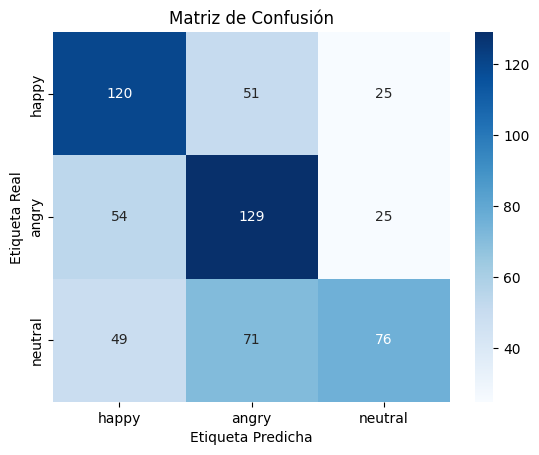

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### Sepformer con wsj0 - anecoico -norep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 36ms/step


0.45666666666666667

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 3.6378242667450564
PESQ: 1.5176223824421564
STOI: 0.6595247926579936


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 28.653246904546577
PESQ: 3.9235408306121826
STOI: 0.9932915385275204


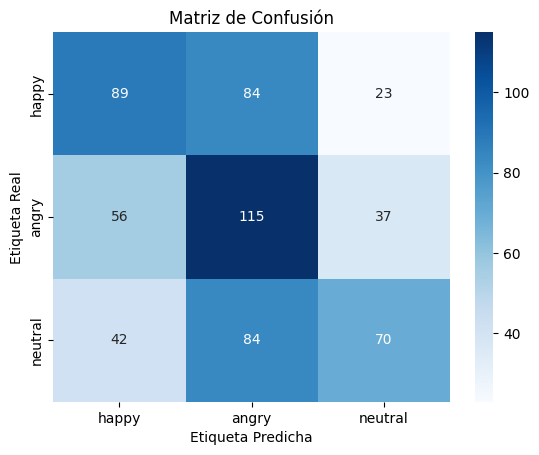

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### Sepformer con librimix - anecoico -rep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-libri2mix", savedir='pretrained_models/sepformer-libri2mix')
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot_rep.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_rep.npy')
limite = len(mini) # Barra de progreso
limite

300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 58ms/step


0.5566666666666666

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 7.926985648991822
PESQ: 1.885368383526802
STOI: 0.7419438161742588


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 32.06199189647031
PESQ: 4.301904678344727
STOI: 0.9977075902167064


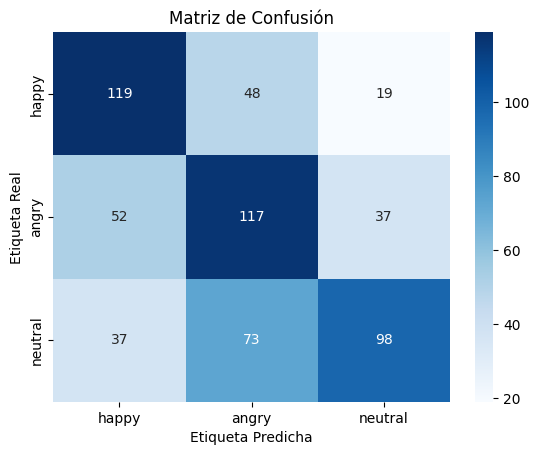

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### Sepformer con wsj0 - anecoico -rep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot_rep.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_rep.npy')
limite = len(mini) # Barra de progreso
limite

300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 36ms/step


0.49333333333333335

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 3.7019078803050545
PESQ: 1.5194130696853
STOI: 0.6711845707852748


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 25.22285901269363
PESQ: 4.149238109588623
STOI: 0.9932663130956001


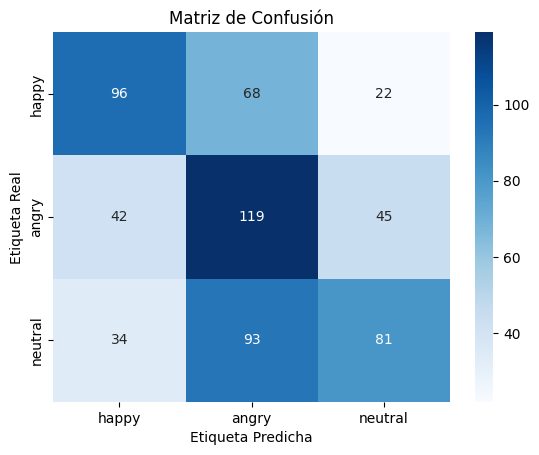

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### Sepformer con librimix - anecoico -norep - overlap

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-libri2mix", savedir='pretrained_models/sepformer-libri2mix')
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
vector_overlap = np.load('/content/drive/MyDrive/Tesis/vector_overlap_3emot_overlap.npy')
limite = len(mini) # Barra de progreso
limite

300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]
  overlap_percentage = vector_overlap[acum_indice]

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  audio1, _ = librosa.load(row.path1, sr=None)
  overlap_samples = int(len(audio1) * overlap_percentage)
  audio1_padded = np.pad(audio1, (overlap_samples, 0), mode='constant')

  sf.write('reference_one.wav', audio1_padded, rate)

  reference1 = 'reference_one.wav'
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = 'reference_one.wav'
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 38ms/step


0.44666666666666666

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: -16.74613296849455
PESQ: 2.0617997616529466
STOI: 0.4566531251445033


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 48.52450905404474
PESQ: 4.612381458282471
STOI: 0.9999302674439101


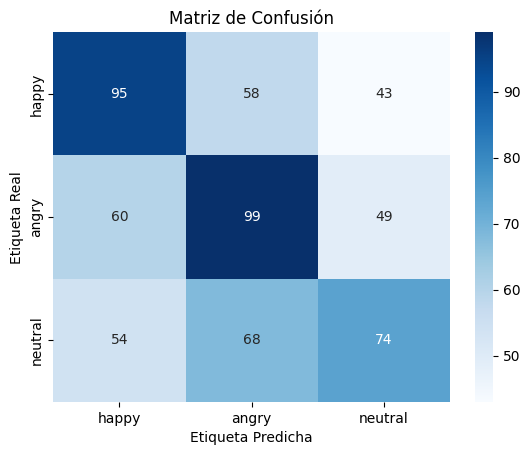

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

##RUIDO


### Sepformer con librimix - ruidoso -norep

In [ ]:
# model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix') #40%
# model = separator.from_hparams(source="speechbrain/sepformer-wham", savedir='pretrained_models/sepformer-wham') # 35 %
model = separator.from_hparams(source="speechbrain/sepformer-whamr", savedir='pretrained_models/sepformer-whamr') # 35 %
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
mini = mini.head(10)
limite = len(mini) # Barra de progreso
limite

10

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

sisdr_impro = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  merged_audio_0, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)
  display(Audio(merged_audio_0, rate=sr))

  merged_audio = sum_noise(merged_audio_0)
  display(Audio(merged_audio, rate=sr))

  score_impro = metrics(merged_audio, merged_audio_0, rate = sr)
  sisdr_impro.append(float(list(score_impro.values())[1]))

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  # MEtricas
  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


0.35

In [ ]:
print('SISDR noise:', statistics.mean(sisdr_impro))

SISDR noise: -5.413615241646767


In [ ]:
sisdr_impro

[-4.5861756801605225,
 -6.146858334541321,
 -5.862518548965454,
 -11.534870862960815,
 3.05460125207901,
 -9.155336022377014,
 -4.988559782505035,
 -2.4736815690994263,
 -10.331848859786987,
 -2.1109040081501007]

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: -9.024457115495325
PESQ: 1.1090214848518372
STOI: 0.44258237948829604


In [ ]:
impro =  [x - y for x, y in zip(sisdr_impro, sisdr)]
print(statistics.mean(impro))

4.326491866242677


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 3.2569636489431257
PESQ: 1.335123062133789
STOI: 0.758667307184102


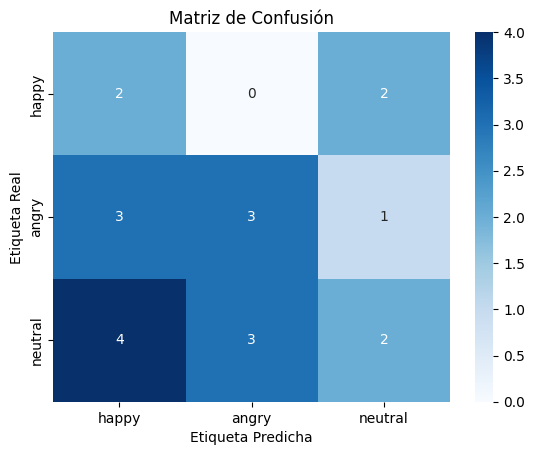

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

## Separacion con Asteroid
CONVTASNET

In [ ]:
#model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_8k") ##
#model2 = ConvTasNet.from_pretrained("mpariente/ConvTasNet_WHAM_sepclean") ##

#model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepnoisy_8k") ##

### ConvTasNet con librimix - anecoico - norep

In [ ]:
model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_8k")

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 61ms/step


0.43

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 3.7518701772826177
PESQ: 1.4554403867324193
STOI: 0.6437991309616539


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 19.599085167880258
PESQ: 3.4571919441223145
STOI: 0.9875276092373811


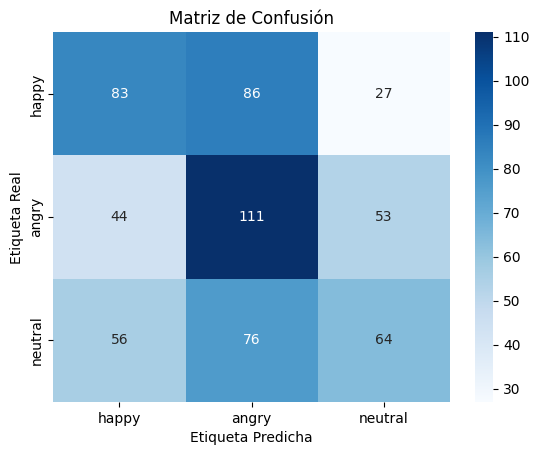

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### ConvTasNet con wsj0 - anecoico - norep

In [ ]:
model2 = ConvTasNet.from_pretrained("mpariente/ConvTasNet_WHAM_sepclean") ##

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 59ms/step


0.3883333333333333

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: -0.2709480461842056
PESQ: 1.2758050976196924
STOI: 0.5717534097417092


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 20.148285393785855
PESQ: 3.404099464416504
STOI: 0.9752689950618187


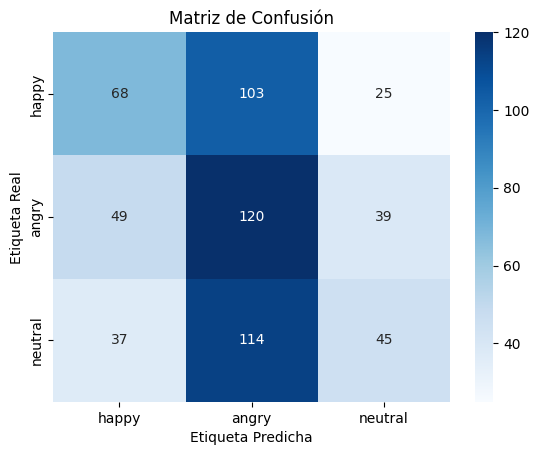

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### ConvTasNet con librimix - anecoico - rep

In [ ]:
model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_8k")

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot_rep.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_rep.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 37ms/step


0.46

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 3.7253353567911325
PESQ: 1.4373587314287821
STOI: 0.6532798571273712


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 22.27668680020153
PESQ: 3.849868059158325
STOI: 0.986500193134602


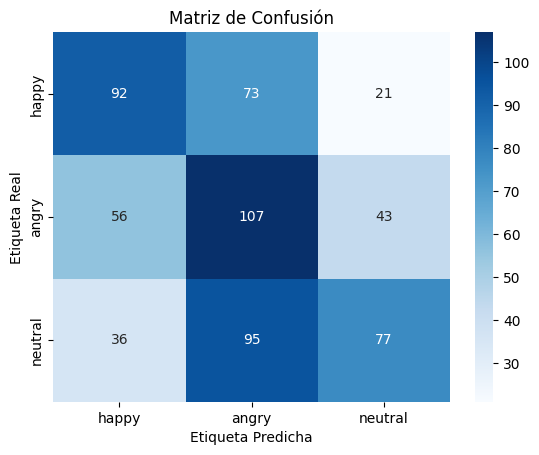

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### ConvTasNet con wsj0 - anecoico - rep

In [ ]:
model2 = ConvTasNet.from_pretrained("mpariente/ConvTasNet_WHAM_sepclean") ##

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot_rep.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_rep.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 38ms/step


0.3516666666666667

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: -0.6547423560260759
PESQ: 1.2422235876321792
STOI: 0.5730197626735011


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 15.725092579071827
PESQ: 3.0504884719848633
STOI: 0.9751701784801634


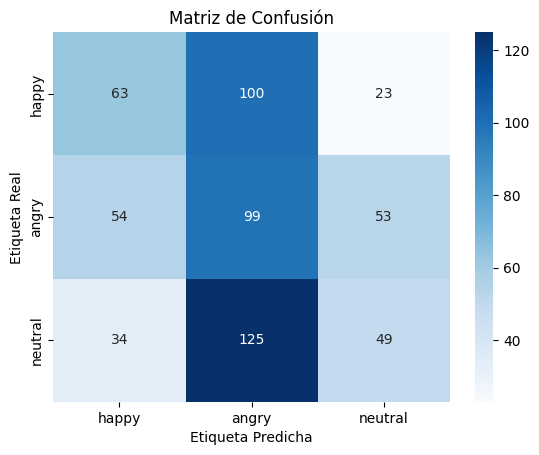

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

### ConvTasNet con librimix - anecoico - norep - overlap

In [ ]:
model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_8k")

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_3emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_3emot_norep.npy')
vector_overlap = np.load('/content/drive/MyDrive/Tesis/vector_overlap_3emot_overlap.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


300

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0


for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]
  overlap_percentage = vector_overlap[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  audio1, _ = librosa.load(row.path1, sr=None)
  overlap_samples = int(len(audio1) * overlap_percentage)
  audio1_padded = np.pad(audio1, (overlap_samples, 0), mode='constant')

  sf.write('reference_one.wav', audio1_padded, rate)

  reference1 = 'reference_one.wav'
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)

Progreso:   0%|          | 0/300 [00:00<?, ?it/s]

19/19 [==============================] - 1s 39ms/step


0.47

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: -25.18320752787932
PESQ: 1.775996442437172
STOI: 0.35574483139812324


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 38.83268206555167
PESQ: 4.565000534057617
STOI: 0.9991507178941885


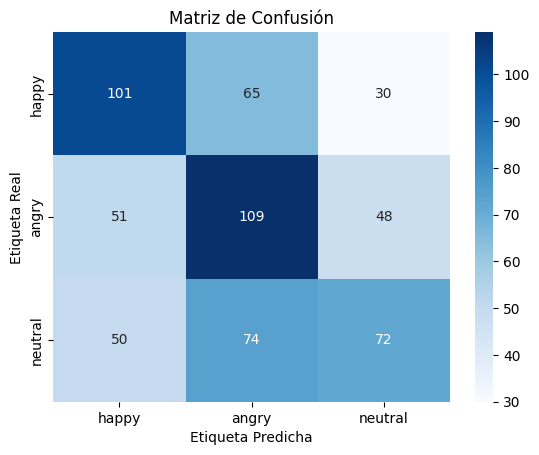

In [ ]:
# Etiquetas específicas para cada clase
etiquetas = ['happy', 'angry', 'neutral']

# Calcular la matriz de confusión utilizando la función confusion_matrix() de sklearn.metrics
cm = confusion_matrix(emotion_list, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn y matplotlib
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Configurar las etiquetas de los ejes
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Mostrar la matriz de confusión
plt.show()

# Demas


#SER 6 emotions
Se especifica las emociones y la frecuencia de muestreo que usara el modelo

In [ ]:
# Cargar arquitectura del modelo desde archivo JSON
with open('/content/drive/MyDrive/Tesis/modeloRCTS_8k_temp_2.json', 'r') as json_file:
    loaded_model_json = json_file.read()
MODEL = model_from_json(loaded_model_json)

# Cargar pesos al modelo
MODEL.load_weights("/content/drive/MyDrive/Tesis/pesosRCTS_8k_temp_2.h5")

In [ ]:
# longo = 180000
#longo = 128000 # 16k
longo = 64000 # 8k
def preprocess_audio(path):
    y, sr = librosa.load(path, sr=None)

    # raw_audio = AudioSegment.from_file(path)
    # samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')

    samples = librosa.util.normalize(y)

    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    if len(trimmed) < longo:
      padded = np.pad(trimmed, (0, longo-len(trimmed)), 'constant')
    else:
      padded = trimmed[:longo]
    return padded, sr

emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

def extract_features(path):
    try:
        y, sr = preprocess_audio(path)

        y = librosa.util.normalize(y)

        # display(Audio(y, rate=sr))
        # print('Frecuencia de muestreo = ', sr)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

    except:
        print(f"Failed for path: {path}")

# Separacion

### Sepformer con librimix - anecoico -norep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-libri2mix", savedir='pretrained_models/sepformer-libri2mix')
mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_6emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_6emot.npy')
limite = len(mini) # Barra de progreso
limite

600

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)
  # display(Audio(merged_audio, rate=sr))

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  # MEtricas
  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/600 [00:00<?, ?it/s]

38/38 [==============================] - 2s 36ms/step


0.3516666666666667

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 7.225421143889173
PESQ: 1.8405850006143252
STOI: 0.7020681120667707


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 27.30568712096265
PESQ: 4.404636859893799
STOI: 0.9981861126249616


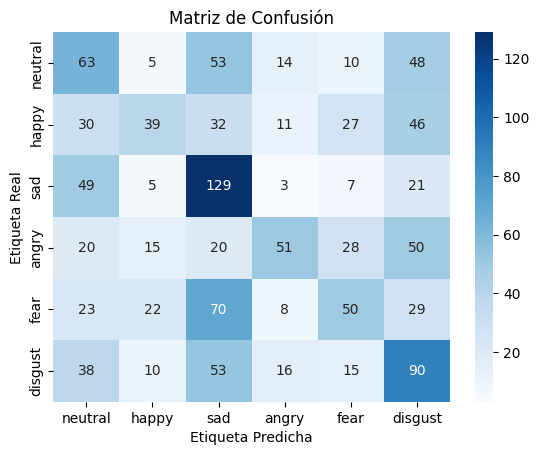

In [ ]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
#labels = ['neutral', 'happy','angry']

cm = confusion_matrix(emotion_list, y_pred, labels=range(6))
# cm = confusion_matrix(np.argmax(y_class, axis=1), y_pred, labels=range(3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

### Sepformer con wsj0 - anecoico -norep

In [ ]:
model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
rate = 8000

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)

  merged_audio, sr, _= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  est_sources = model.separate_file(path='merge.wav')
  person_two = est_sources[:, :, 1].detach().cpu().squeeze()
  person_one = est_sources[:, :, 0].detach().cpu().squeeze()

  sf.write('person_one.wav', person_one, rate)
  sf.write('person_two.wav', person_two, rate)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'person_one.wav'
  test2 = 'person_two.wav'

  extract_features('person_one.wav')
  extract_features('person_two.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

# Finalizar la barra de progreso
barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred) # 0.533333333

Progreso:   0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

In [ ]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
#labels = ['neutral', 'happy','angry']

cm = confusion_matrix(emotion_list, y_pred, labels=range(6))
# cm = confusion_matrix(np.argmax(y_class, axis=1), y_pred, labels=range(3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

### ConvTasNet con librimix - anecoico - norep

In [ ]:
model2 = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_8k")

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_6emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_6emot.npy')
limite = len(mini) # Barra de progreso
limite

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


600

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

Progreso:   0%|          | 0/600 [00:00<?, ?it/s]

38/38 [==============================] - 2s 58ms/step


0.2725

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

SISDR: 3.3909876266956425
PESQ: 1.452250007490317
STOI: 0.6156162717522399


In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

SISDR: 20.581461276931492
PESQ: 3.7953941822052
STOI: 0.9858198676513078


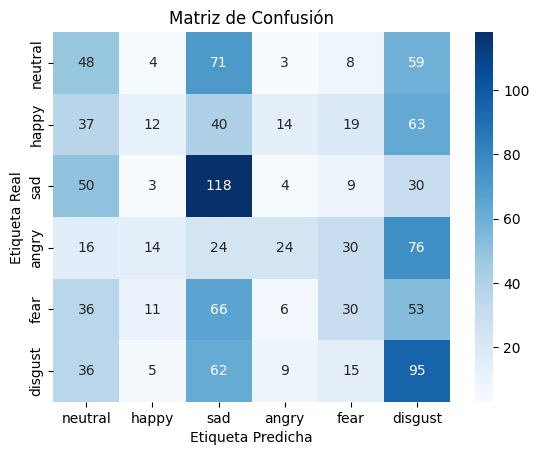

In [ ]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
#labels = ['neutral', 'happy','angry']

cm = confusion_matrix(emotion_list, y_pred, labels=range(6))
# cm = confusion_matrix(np.argmax(y_class, axis=1), y_pred, labels=range(3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

### ConvTasNet con wsj0 - anecoico - norep

In [ ]:
model2 = ConvTasNet.from_pretrained("mpariente/ConvTasNet_WHAM_sepclean") ##

mini = pd.read_csv('/content/drive/MyDrive/Tesis/directorio_mezcla_6emot.csv')
vector_volumen = np.load('/content/drive/MyDrive/Tesis/vector_volumen_6emot.npy')
limite = len(mini) # Barra de progreso
limite

In [ ]:
barra_progreso = tqdm(total=limite, desc="Progreso")

zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

pesq = []
sisdr = []
stoi = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

acum_indice = 0

overlap_percentage = 0

for index, row in mini.iterrows():
  volume_ratio = vector_volumen[acum_indice]

  audio1, _ = librosa.load(row.path1, sr=None)
  audio2, _ = librosa.load(row.path2, sr=None)
  merged_audio, sr, flag= merge_audios(row.path1, row.path2, overlap_percentage, volume_ratio)

  sf.write('merge.wav', merged_audio, rate)

  model2.separate('merge.wav',force_overwrite=True)

  person_one, _ = librosa.load('merge_est1.wav', sr=None)
  person_two, _ = librosa.load('merge_est2.wav', sr=None)

  reference1 = row.path1
  reference2 = row.path2

  test1 = 'merge_est1.wav'
  test2 = 'merge_est2.wav'

  extract_features('merge_est1.wav')
  extract_features('merge_est2.wav')

  scores = metrics(test2, reference2)
  com_metrics = float(list(scores.values())[1])

  if com_metrics < 0:
    scores = metrics(test2, reference1)

    if float(list(scores.values())[1]) < com_metrics:
      emotion_list.append(encode(row.emotion1))
      emotion_list.append(encode(row.emotion2))
    else:
      reference2 = row.path1
      reference1 = row.path2
      emotion_list.append(encode(row.emotion2))
      emotion_list.append(encode(row.emotion1))
  else:
    emotion_list.append(encode(row.emotion1))
    emotion_list.append(encode(row.emotion2))

  scores1 = metrics(test1, reference1)
  scores2 = metrics(test2, reference2)

  pesq.append(float(list(scores1.values())[0]))
  sisdr.append(float(list(scores1.values())[1]))
  stoi.append(float(list(scores1.values())[2]))
  pesq.append(float(list(scores2.values())[0]))
  sisdr.append(float(list(scores2.values())[1]))
  stoi.append(float(list(scores2.values())[2]))

  acum_indice+=1
  barra_progreso.update(1)

barra_progreso.close()

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y_pred = np.argmax(MODEL.predict(X), axis=1)

emotion_list = np.array(emotion_list)

accuracy_score(emotion_list, y_pred)
# 0.178 accuracy

In [ ]:
print('SISDR:', statistics.mean(sisdr))
print('PESQ:', statistics.mean(pesq))
print('STOI:', statistics.mean(stoi))

In [ ]:
print('SISDR:', max(sisdr))
print('PESQ:', max(pesq))
print('STOI:', max(stoi))

In [ ]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
#labels = ['neutral', 'happy','angry']

cm = confusion_matrix(emotion_list, y_pred, labels=range(6))
# cm = confusion_matrix(np.argmax(y_class, axis=1), y_pred, labels=range(3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()